# Deep Learning with Python

## 5.3 Using a pretrained convnet

> 使用预训练的卷积神经网络

对于小型图像数据集，我们常用的一种高效的方法是利用预训练网络（pretrained network）来构建深度学习模型。预训练网络是之前在大型数据集上训练好的网络（通常是在大型图片分类任务上训练好的）。如果预训练集用的数据足够多，模型足够泛化，那么预训练网络学到的空间层次结构就可以有效地作为通用模型来反应现实的视觉世界，因此就可用于各种不同的计算机视觉问题，哪怕新的问题和原始任务完全扯不上关系。

例如，我们可以用一个在 ImageNet (这个数据集有140万张图像，1000个不同的类别，主要是动物和各种日常用品)完成预训练的网络来处理猫狗分类的问题。我们将使用的是 VGG16 这个架构。

使用预训练网络有两种方法：*特征提取*(feature extraction)和*微调模型*(fine-tuning)。

### 特征提取

特征提取是使用之前的网络学到的表示来从新样本中提取出需要的特征，输入一个新的分类器，从头开始训练。

在前面的卷积神经网络例子中，我们知道，我们用来图片分类的模型可以分成两部分：

- 卷积基（convolutional base）：前面的卷积、池化层；
- 分类器（classifier）：后面的密连接层；

所以对于卷积神经网络，**特征提取**就是取出之前训练好的网络的卷积基，把新的数据输入进去跑，然后拿其输出去训练一个新的分类器：

![保持卷积基不变，改变分类器](https://tva1.sinaimg.cn/large/007S8ZIlgy1ggvimux4ttj314l0u0jv4.jpg)

注意，只复用卷积基，而不复用分类器。卷积基是用来提取特征的，这个可以相同；但由于每个问题的分类不同，理应使用不同的分类器；并且有的问题中特征的位置是有用的，而我们把特征图转到 Dense 层的时候这些位置特征就丢失了，所以并不是所有问题都是用 Dense 去简单的完成分类的，所以不应该无脑套用分类器。

在预训练网络中，能提取的特征表示的通用程度取决于于其深度。越少的层越通用（比如，图片的颜色、边缘、纹理之类的），越多的层就会包含越多的抽象信息（比如，有一个猫的眼睛啊之类的）。所以如果预训练网络处理的原始问题和我们当前要处理的问题差距太大，就只因该使用比较少的前几层，而不要用整个卷积基。

现在，来做实践了，我们要用在 ImageNet 上预训练的 VGG16 模型来处理猫狗分类的问题，我们将保持卷积基不变，改变分类器。

VGG16 模型是 Keras 有内置的，直接用就好了：

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',        # 指定模型初始化的权重检查点
                  include_top=False,         # 是否包含最后的密集连接层分类器
                  input_shape=(150, 150, 3)) # 输入的形状，不传的话能处理任意形状的输入

模型是要从这里下载的：[https://github.com/fchollet/deep-learning-models/releases](https://github.com/fchollet/deep-learning-models/releases)

如果让他自己下比较慢的话，可以考虑手动下载安装。参考 vgg16 的源码: `/usr/local/lib/python3.7/site-packages/keras_applications/vgg16.py`，发现它是调用一个 get_file 来获取模型的：

```python
weights_path = keras_utils.get_file(
    'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    WEIGHTS_PATH_NO_TOP,
    cache_subdir='models',
    file_hash='6d6bbae143d832006294945121d1f1fc')
```

这里看到他是从一个子目录 `models` 里读取模型的，还有这个 `keras_utils.get_file` 就是 `/usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/utils/data_utils.py` 第 150 行左右的 get_file 函数，文档注释里写了，东西默认是放到 `~/.keras` 这个目录的。

总之，就是把模型下载下来放到 `~/.keras/models` 里就好了。

还有注意加不加top(最后的分类器)，下载的模型大小差距还是很大的：

![不同配置的VGG16预训练模型的大小](https://tva1.sinaimg.cn/large/007S8ZIlgy1ggw35kvawgj30t407uta8.jpg)

总之，最后完了会得到一个 conv_base 模型，这个模型还是很容易理解的，用到的都是我们之前已经学过的东西：

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

注意，最前面的输入已经调成了我们希望的`(150, 150, 3)`，最后的输出是`(4, 4, 512)`，在后面我们要连上我们自己的分类器。有两种办法：

1. 在这个卷积基上跑我们现在的数据集，然后把结果放到个 Numpy 数组里面，保存到磁盘，然后以这个数组为输入，扔到个密连接的网络里面去训练。这种办法比较简单，也只需要计算一次消耗最大的卷积基部分。但是，这种办法不能使用数据增强。
2. 拓展 conv_base，往它后面加 Dense 层，然后在输入数据上端到端运行整个网络，这样可以使用数据增强，但计算代价比较大。

首先，我们做第一种。

#### 快速特征提取，不数据增强

重述一般，这种方法保存我们的数据通过 conv_base 后的输出，然后将这些输出作为输入放到一个新模型里。

这里还是用 ImageDataGenerator 把图片、标签提取到 Numpy 数组。然后调用 conv_base 的 predict 方法来用预训练模型提取特征。

In [3]:
# 使用预训练的卷积基提取特征

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/Volumes/WD/Files/dataset/dogs-vs-cats/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))    # 这个要符合之前 conv_base.summary() 最后一层的输出的形状
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:    # 一批一批加数据
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:    # generator 会生成无限的数据哦，break 要自己控制
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


之后我们是要接密连接层的分类器来着，所以这里先把张量压扁了：

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

然后就是做密连接的分类器了，还是用 dropout 正则化：

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5905 - acc: 0.6840 - val_loss: 0.4347 - val_acc: 0.8430
Epoch 2/30
2000/2000 [==============================] - 1s 640us/sample - loss: 0.4339 - acc: 0.8060 - val_loss: 0.3566 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 1s 638us/sample - loss: 0.3583 - acc: 0.8475 - val_loss: 0.3184 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s 641us/sample - loss: 0.3099 - acc: 0.8775 - val_loss: 0.3053 - val_acc: 0.8730
Epoch 5/30
2000/2000 [==============================] - 1s 638us/sample - loss: 0.2804 - acc: 0.8900 - val_loss: 0.2796 - val_acc: 0.8990
Epoch 6/30
2000/2000 [==============================] - 1s 637us/sample - loss: 0.2658 - acc: 0.8995 - val_loss: 0.2758 - val_acc: 0.8870
Epoch 7/30
2000/2000 [==============================] - 1s 641us/sample - loss: 0.2476 - acc: 0.9100 - val_loss: 0.2629 - val_

看结果了：

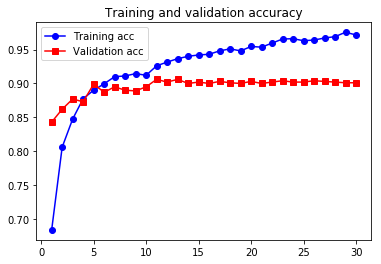

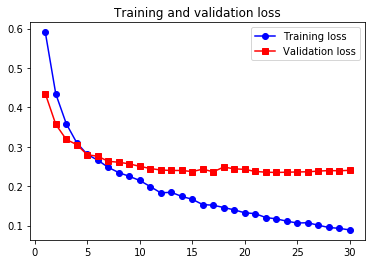

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

可以看到，效果还是很不错的接近 90% 的准确率。但问题也还是有，因为没有数据增强，过拟合还是严重的，基本从一开始就在过拟合了。对这种太小的图片数据集，没有数据增强，一般都是不太行的。

### 带数据增强的特征提取

第二种办法，拓展 conv_base，往它后面加 Dense 层，然后在输入数据上端到端运行整个网络。

这个办法计算代价非！常！高！，基本只能用 GPU 跑。没 GPU 就被用这个了。

在 Keras 里，我们可以像添加层一样把一个模型添加到 Sequential model 里：

In [8]:
# 在卷积基的基础上添加密集连接分类器

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

看一下模型的样子：

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


注意，在用这种用预训练模型的方法时，一定要**冻结卷积基**，也就是告诉网络，在训练过程种不要去更新卷积基的参数！这个很重要，不这么做的话预训练好的模型就会被破坏，到头来相当于你是从头训练的，那样就失去用预训练的意义了。

In [11]:
# 冻结卷积基
conv_base.trainable = False

这样做之后，训练模型时就只会去不断更新 Dense 层的权重了：

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


接下来，就可以上数据增强，训练模型了：

In [ ]:
# 利用冻结的卷积基端到端地训练模型

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)    # 注意 test 不增强

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

P.S. 这个在我的 CPU 上跑，一轮大概要15分钟，30轮，，我放弃了。我用 Kaggle 跑了这个，一轮才30秒😭：

![运行结果图](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh5lk985mvj30m60vqtcp.jpg)

### Fine-tuning 微调模型

（我比较喜欢 Fine-tuning 这个词，“微调”反而没内味儿了。）

Fine-tuning 是补充特征提取，进一步优化模型的。Fine-tuning 做的是将卷积基顶部(靠后面的)的几层**解冻**，把解冻的几层和新增加的部分(全连接分类器)联合训练。这个方法稍微调整了预训练模型里面那些高级抽象的表示(也就是那些接近顶层的)，使之更适合我们手头的问题。

![Fine-tuning 示意图，微调了 VGG16 的最后一个卷积块](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh5nq823wfj30ik0t0tbf.jpg)

注意，必须先把最后的全连接分类器训练好，才能去 Fine-tune 卷积基顶部的 Conv 块，不然就会把预训练的成果完全破坏调。

所以，Fine-tuning 需要按照以下步骤：

1. 在已经训练好的网络(base network，基网络)上添加我们自己的网络(比如分类器);
2. 冻结基网络;
3. 训练自己添加的那一部分;
4. 解冻基网络的部分层;
5. 联合训练解冻的层和自己的那部分;

前三步都和特征提取做的是一样的，所以我们从第四步开始。首先再看一下我们的 VGG16 卷积基：

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

我们将解冻 block5_conv1, block5_conv2 和 block5_conv3 来完成 Fine-turning：

In [ ]:
# 冻结直到某一层的所有层

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 微调模型

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),    # 这里用的学习率(lr)很小，是希望让微调的三层表示变化范围不要太大
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

这个也是在 Kaggle 跑的：

![在 Kaggle 训练的最后几轮输出](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh6fkf1r4hj31jw0gaq87.jpg)

![训练历史图线](https://tva1.sinaimg.cn/large/007S8ZIlgy1gh6flamoy7j30o60wkdl5.jpg)

我不知道为什么我做出来的和书上差距很大，我反复看了好过错都没发现有什么问题，即使我用作者给的 Notebook 来跑也是😂，可能是数据集的问题？不管了，就这样吧。

最后，来看看在测试集上的结果：

```python
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
```

书上的结果准确率有 97% 了，，我，我的还不到 95%，害。